# Build an end-to-end Recommender using Amazon SageMaker
> In this tutorial, we show you how to improve the personalized ranking of an online retail use case using Implicit BPR, available in AWS Marketplace, and Amazon SageMaker. We further show you how to use SageMaker to collect, analyze, clean, prepare, train, and deploy the model to perform both batch and real-time inferences on the trained model.

- toc: true
- badges: false
- comments: true
- categories: [SageMaker, ALS, Implicit]
- image:

## Introduction

Duration: 5

A Recommender system is an automated form of software mechanism that leverages the algorithms and data to improve the discovery of the products or items that are most relevant to a particular user. Their task is not only to reveal to users the items they are looking for but also personalize their experience based on various techniques, such as:

1. Leveraging past interactions/purchases/likes of this user.
2. A recommendation based on other user's similarity to this user and what they liked/purchased.
3. A recommendation based on their demographic data.

An algorithm optimization technique such as Bayesian personalized ranking (BPR) adds an absolute value to improve recommender systems. BPR works on an implicit feedback dataset. It deals with one-class collaborative filtering problems by transforming them into a ranking task.

Using BPR increases the chances of the user getting recommendations containing a diverse selection of items and liking at least one item. The increased personalization can also positively influence customer satisfaction and retention.

### What you'll learn?

In this tutorial, we show you how to improve the personalized ranking of an online retail use case using [Implicit BPR](https://aws.amazon.com/marketplace/pp/Outpace-Systems-Implicit-BPR/prodview-xgpovurjdgtga?&ref_=sa_campaign_niravraj), available in [AWS Marketplace](https://aws.amazon.com/marketplace?&ref_=sa_campaign_niravraj), and [Amazon SageMaker](https://aws.amazon.com/sagemaker/?&ref_=sa_campaign_niravraj). We further show you how to use SageMaker to collect, analyze, clean, prepare, train, and deploy the model to perform both batch and real-time inferences on the trained model.

### Why is this important?

- Implicit models are important to learn and use
- SageMaker is a powerful tool for building and serving recommender systems

### How it will work?

1. Download the Online Retail Data Set from the UCI Machine Learning repository to SageMaker notebook instance. Use SageMaker notebook instance to collect, analyze, cleanse and prepare the downloaded datasets using this sample Jupyter notebook. Refer to the following diagram.

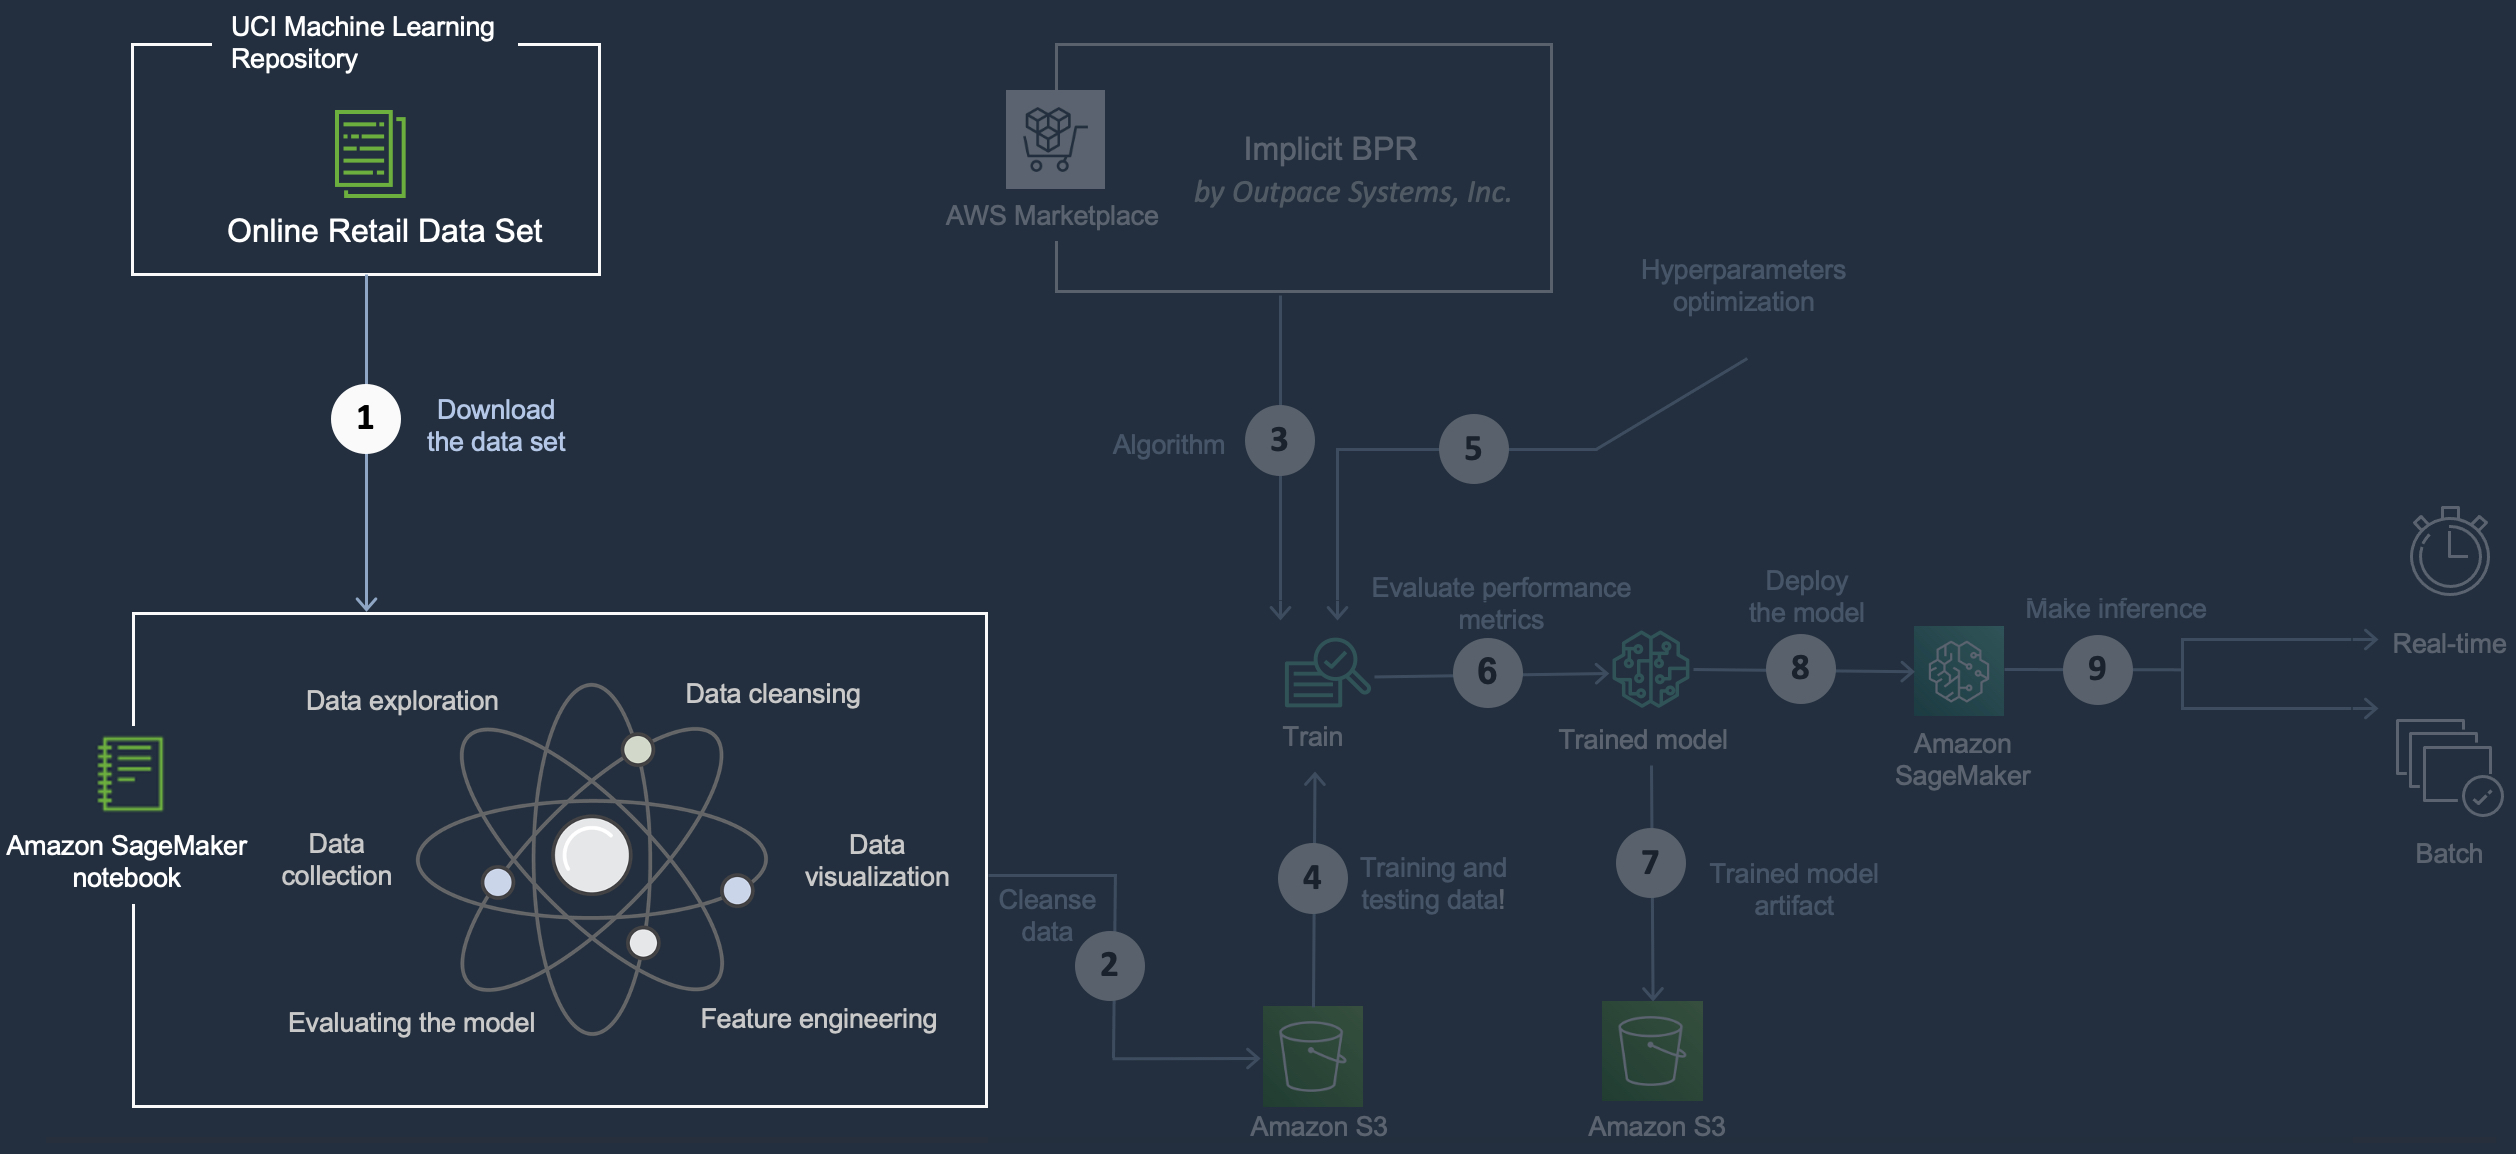

2. Store the final training and testing datasets to Amazon S3.
3. Use the Implicit BPR algorithm listing in AWS Marketplace to train the ML model.
4. Present the cleanse training and testing datasets to the model training process.
5. Optionally, tune the hyperparameters supported by the algorithm based on its specification. Refer to the following diagram.

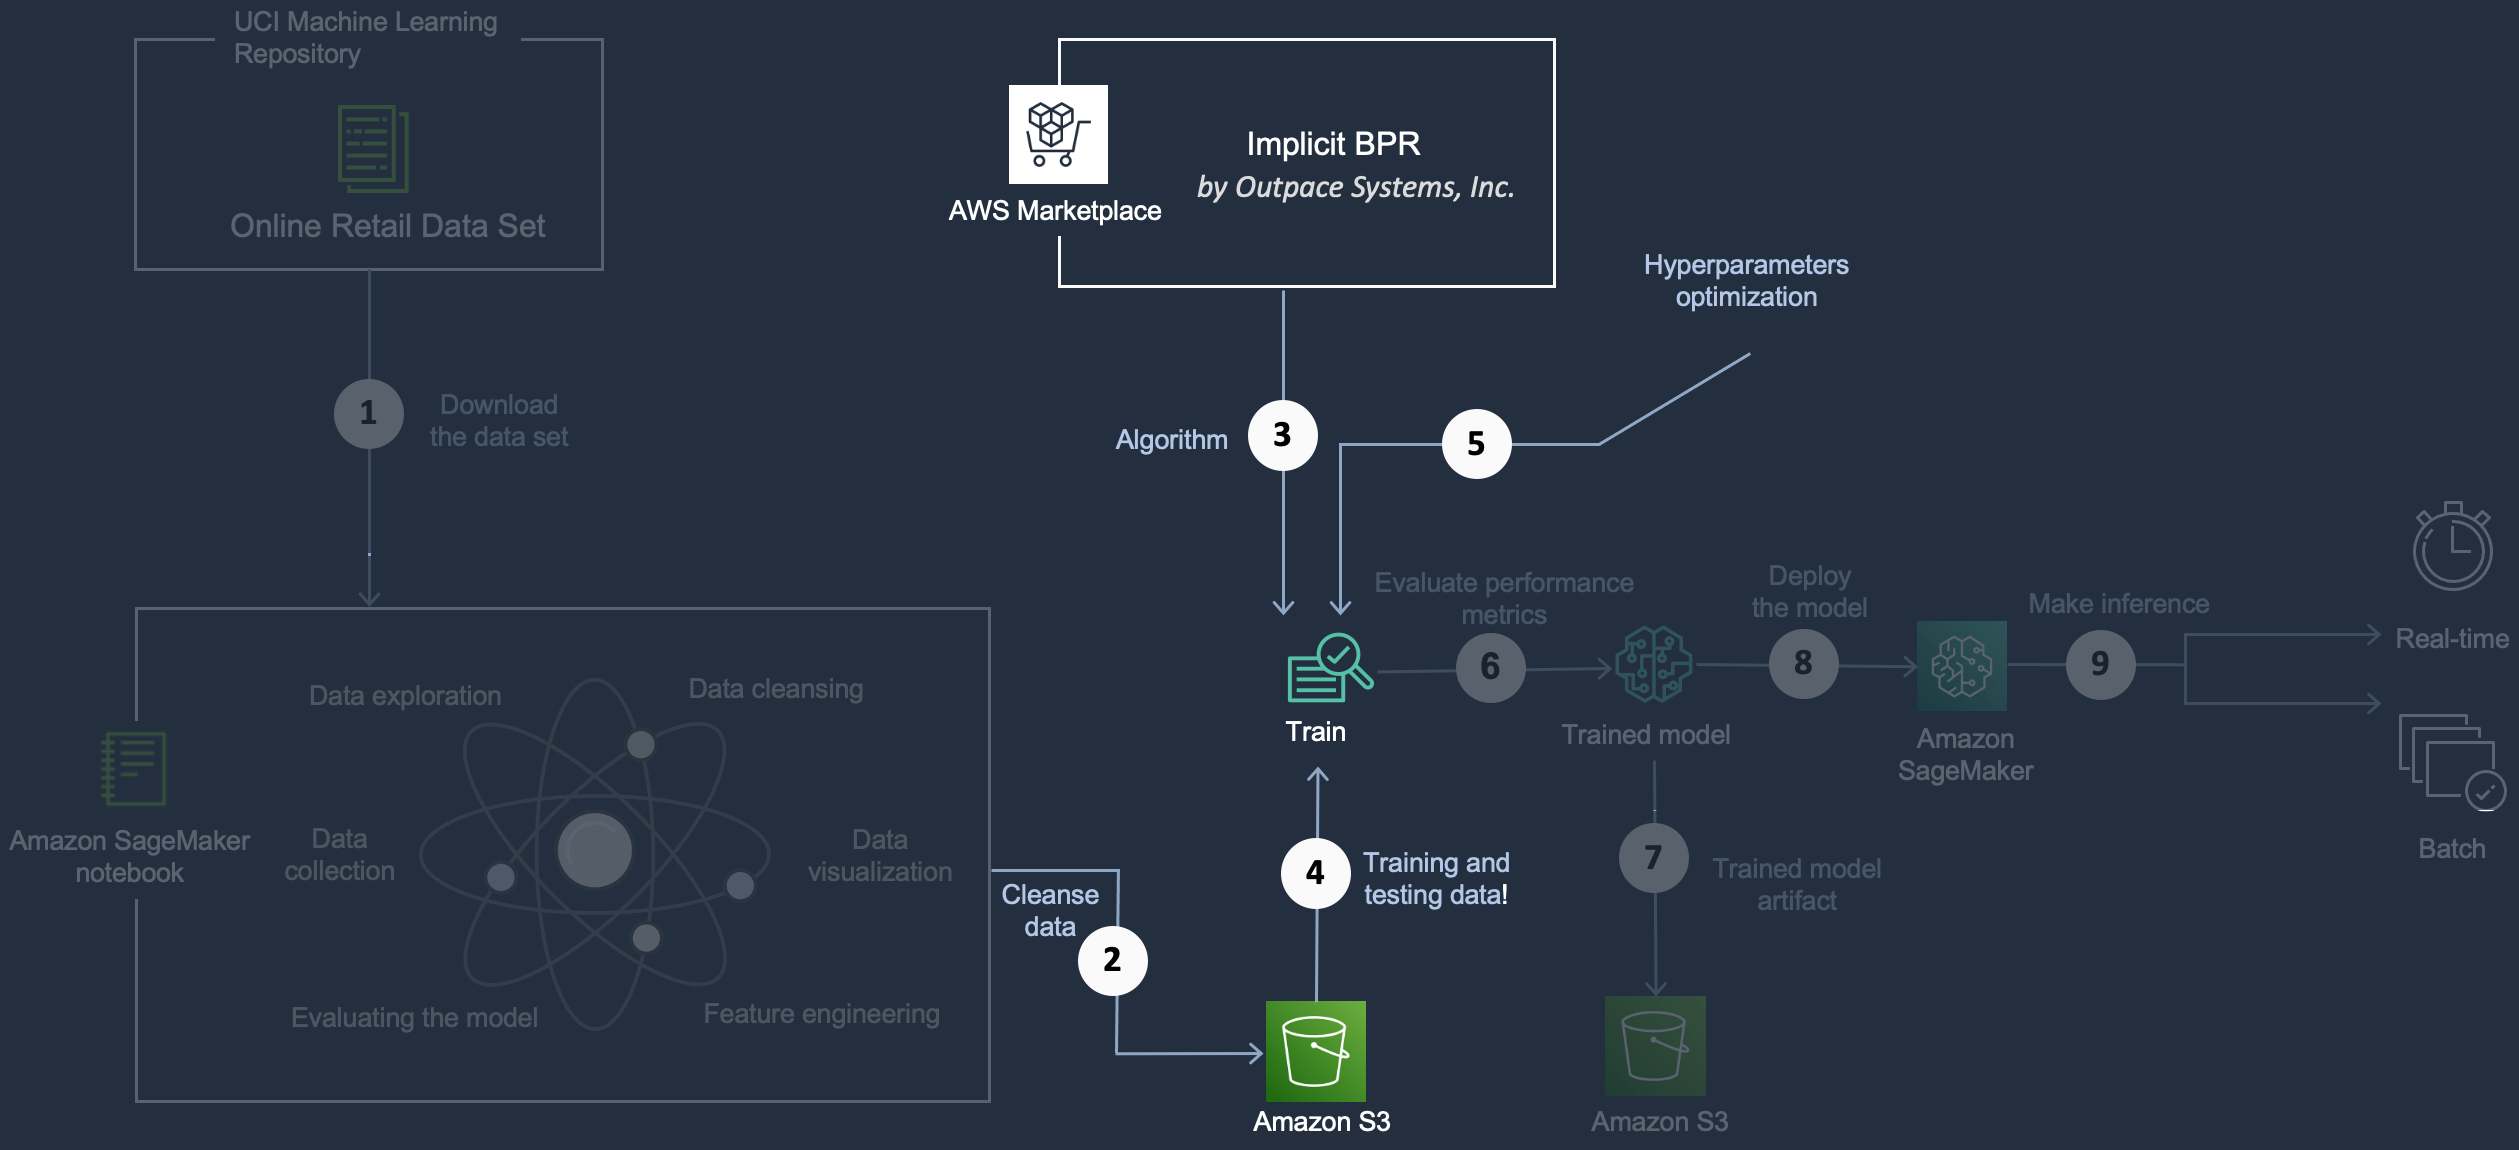

6. Evaluate and visualize the quality and the performance metrics of the trained model.
7. The final trained model artifact is stored in the Amazon S3 bucket.
8. Use the SageMaker hosting service to host the trained model to perform both the batch transform and real-time inferences.
9. Build request payloads for both a batch and a real-time use case and make an inference request. Both modes facilitate interactive experimentation with the trained model. Refer to the following diagram.

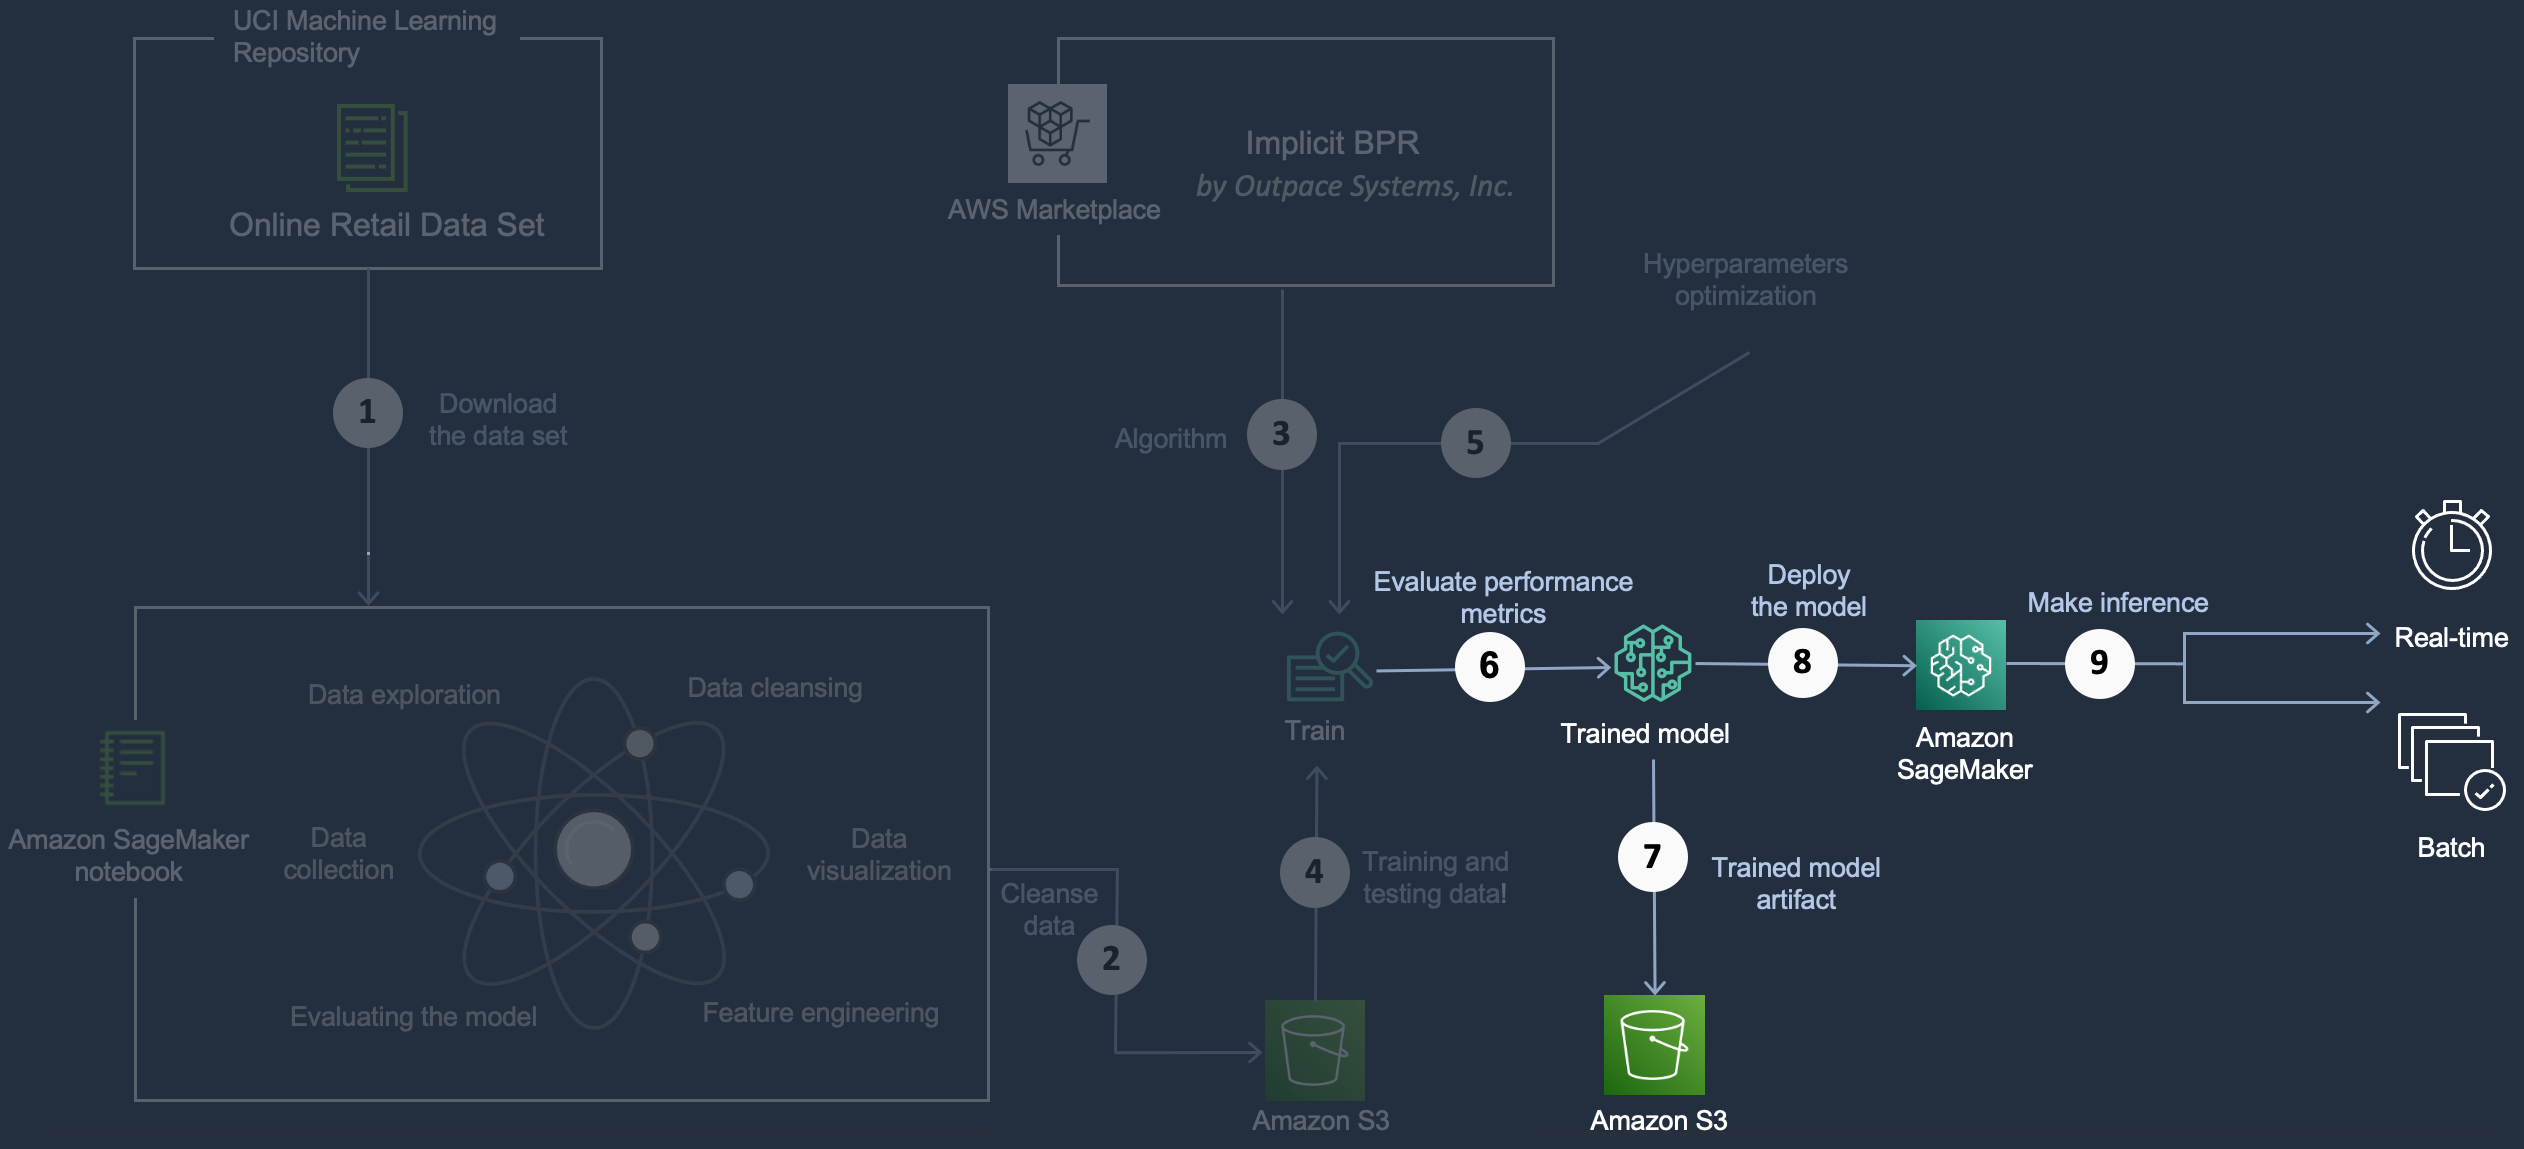

### Who is this for?

- People who are interested in using cloud tool for training and/or deploying recommender systems
- People looking to learn AWS SageMaker

### Important resources

- [Complete SageMaker notebook](https://www.notion.so/1ba5245e195fd4fd296aaf79e0e55cc9)

<!---------------------------->

## Subscribe to Implicit BPR in AWS Marketplace

Duration: 5

To subscribe to the algorithm in AWS Marketplace, follow these steps.

1. Log in to your AWS account and open the [Implicit BPR](https://aws.amazon.com/marketplace/pp/Outpace-Systems-Implicit-BPR/prodview-xgpovurjdgtga?&ref_=sa_campaign_niravraj) (V 0.9.36) listing.
2. Read Highlights, Product Overview, Usage information, and Additional resources and review the supported instance types.
3. Choose **Continue to Subscribe**.
4. Review End user license agreement, Support Terms, and Pricing Information.
5. To subscribe to the Implicit BPR algorithm, choose **Accept Offer**.
6. Choose **Continue to Configuration** and then choose a Region. A product ARN will appear on the same page. Copy it, as this is the algorithm ARN that you must specify in your training job.



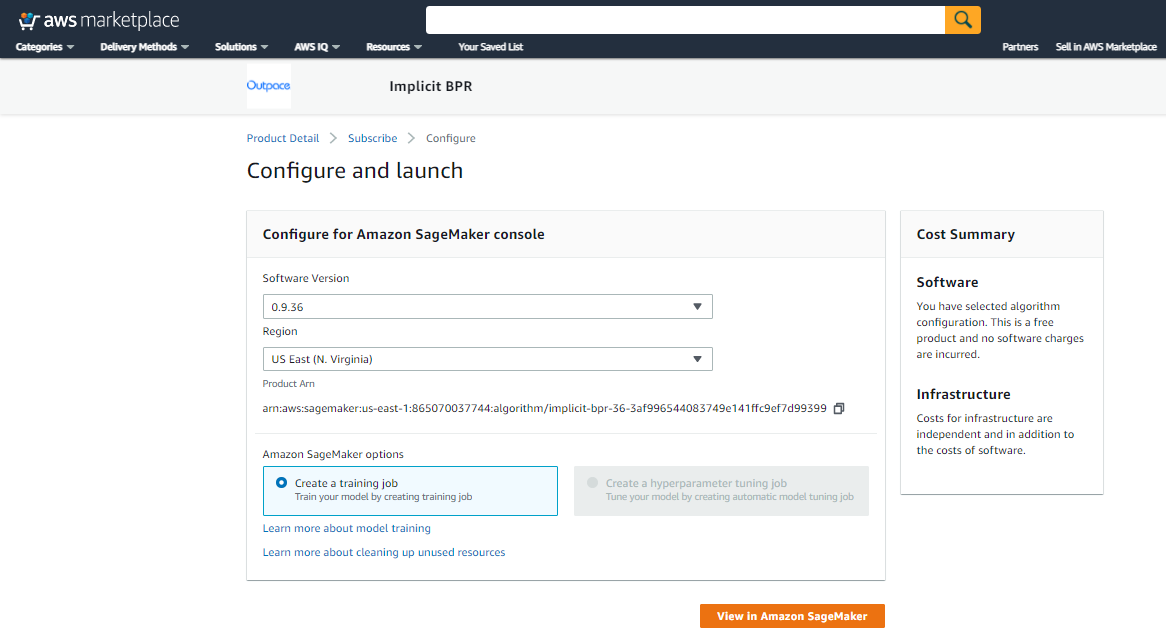

### **Notes:**

1. If the continuous configuration button is active, your account already has a subscription to this listing.
2. Once you click on Continue to configuration button and then choose region, you will see that a product ARN will appear. This is the algorithm ARN that you need to specify in your training job.

<!---------------------------->

## Set up the notebook instance

Duration: 5

We will be needing an AWS account. If you do not have an AWS account, please create one. It is free! Refer to [this](https://aws.amazon.com/premiumsupport/knowledge-center/create-and-activate-aws-account/) for details.

After logging into your AWS account, go to Amazon SageMaker service. The page will look like this:

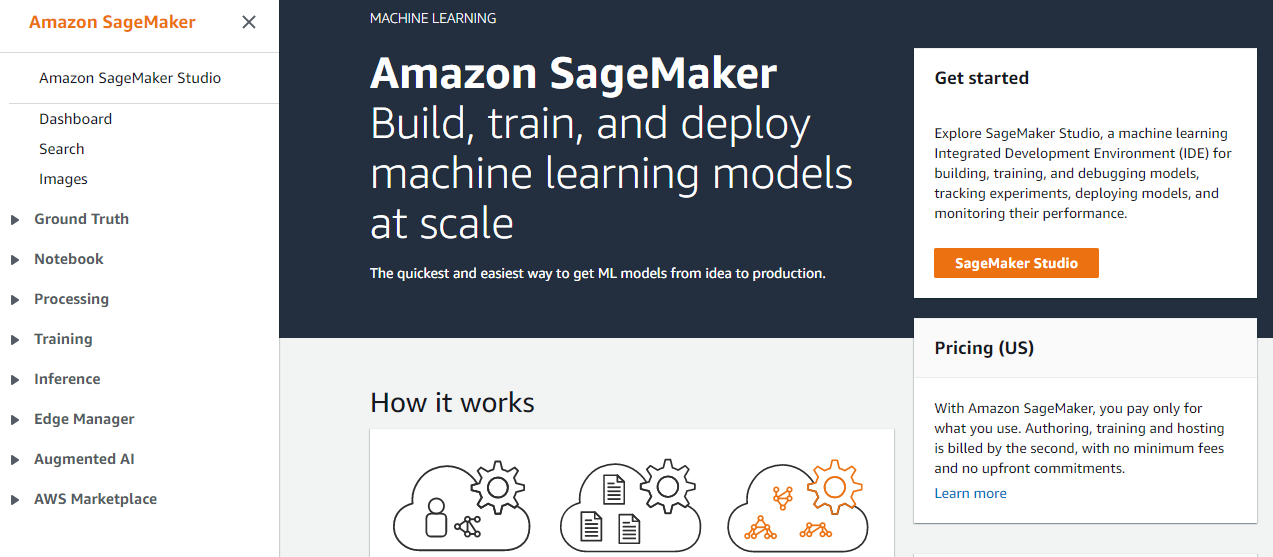

Now, we can either use SageMaker studio or a notebook instance.

### If you are using Notebook instance

First, create an Amazon SageMaker notebook instance by following the instructions at [Create a Notebook Instance](https://docs.aws.amazon.com/sagemaker/latest/dg/howitworks-create-ws.html?ref_=sa_campaign_niravraj) in the *Amazon SageMaker Developer Guide*. Please use Classic Jupyter mode to be able correctly to render visualization. Pick instance type 'ml.c5.2xlarge' or larger.

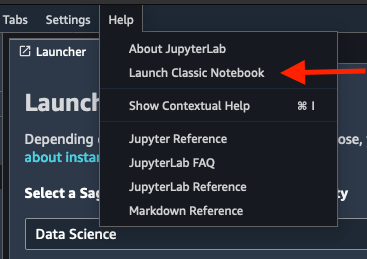

Next, open the notebook instance. You should have access to all SageMaker examples. To follow along with the rest of this post, scroll down to the **AWS Marketplace** section and choose **use** next to *recommender_system_with_implicit_bpr.ipynb*.

### If you are using Studio

Inside the AWS SageMaker Studio, start the "Data Science" kernel, which powers all of our notebook interactions, by clicking on "No Kernel" in the Upper Right and select the "Data Science Kernel". 

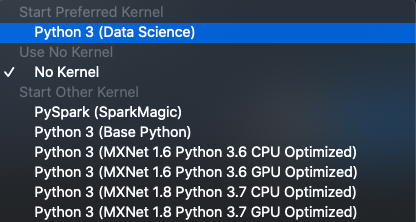

Note: You cannot continue until the kernel is started. Please wait until the kernel is started before continuing !!!!

The interface would look like this:

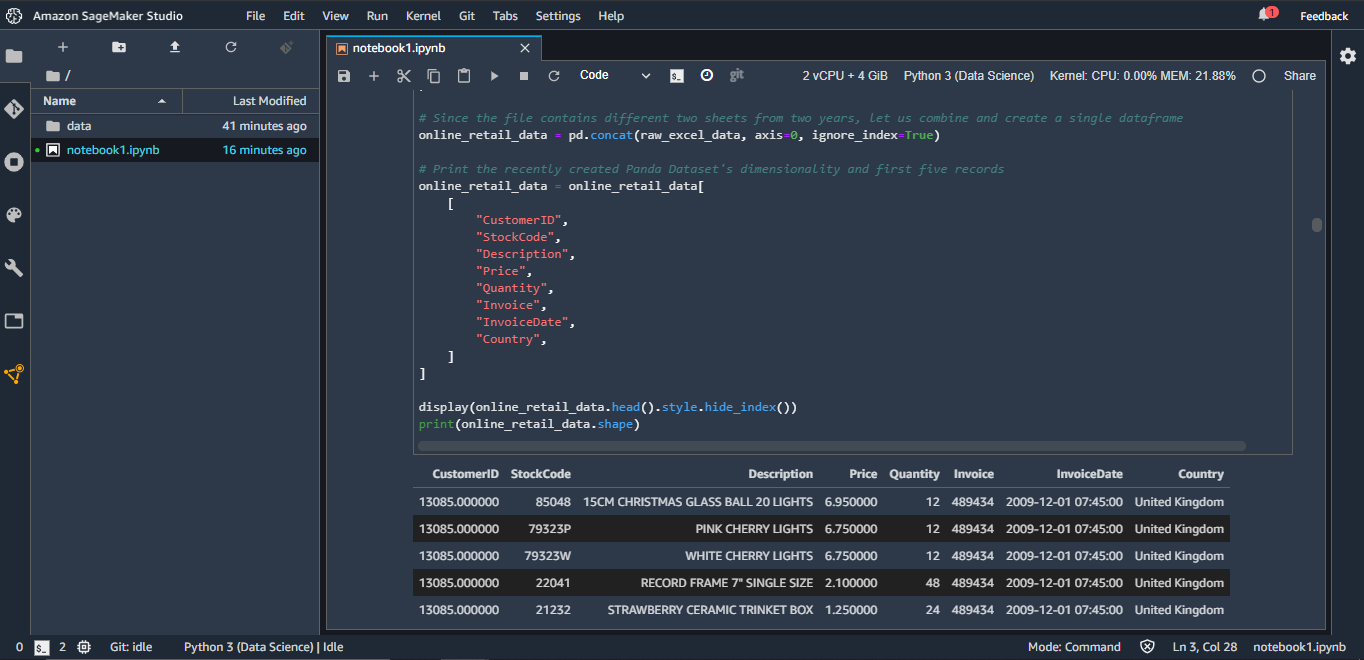

<!---------------------------->

## Setup the environment

Duration: 10

### Algorithm ARN

```python
algorithm_arn = "arn:aws:sagemaker:us-east-1:865070037744:algorithm/implicit-bpr-36-3af996544083749e141ffc9ef7d99399"
```

### Install necessary libraries and their required versions

*Please ignore all WARNINGs and ERRORs from the pip install's below*

```python
import sys

!{sys.executable} -m pip install --disable-pip-version-check -q pandas==1.1.5
!{sys.executable} -m pip install --disable-pip-version-check -q numpy==1.19.5
```

### Import necessary libraries

```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sagemaker
import json
import boto3

from sagemaker import AlgorithmEstimator
from sagemaker import get_execution_role, local, Model, utils, fw_utils, s3
from sagemaker.predictor import json_serializer
from sagemaker.analytics import TrainingJobAnalytics
from sklearn.model_selection import train_test_split
from botocore.exceptions import ClientError
from io import StringIO
from urllib.parse import urlparse
from IPython.display import Markdown as md, display

# Print settings
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 10)
```

### Account/Role setup

```python
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role_arn = get_execution_role()

boto3_sm_runtime = boto3.client("sagemaker-runtime")
boto3_sm_client = boto3.client("sagemaker")
boto_s3_client = sagemaker_session.boto_session.client("s3")
```

### S3 setup

```python
s3_bucket = sagemaker_session.default_bucket()
s3_common_prefix = "sagemaker/implicit-bpr"
s3_training_prefix = s3_common_prefix + "/training"
s3_testing_prefix = s3_common_prefix + "/test"
s3_training_input_prefix = s3_training_prefix + "/data"
s3_testing_input_prefix = s3_testing_prefix + "/data"
s3_training_jobs_prefix = s3_training_prefix + "/jobs"
s3_training_data_file_name = "cleaned_online_retail_train_data.csv"
s3_test_data_file_name = "cleaned_online_retail_test_data.csv"

# S3 batch request inputs
s3_batch_input_dir_prefix = s3_common_prefix + "/batch-inference/jobs"
s3_batch_request_file_name = "recommendation.requests"

# Construct training and transform job Name
job_name_prefix = "implicit-bpr-online-retail-training"
job_output_path = "s3://{}/{}/{}/".format(s3_bucket, s3_training_jobs_prefix, job_name_prefix)
transform_job_name_prefix = "implicit-bpr-online-retail-batch-transform"
```

### Instance types

```python
# Define the different ML instance types
compatible_training_instance_type = "ml.c5.2xlarge"
compatible_batch_transform_instance_type = "ml.c5.2xlarge"
compatible_real_time_inference_instance_type = "ml.c5.2xlarge"
```

### Path configurations

```python
# Reference to the data directory
DATA_DIR = "data"
# Reference to the original dataset
DATASET_DIR = DATA_DIR + "/" + "dataset"

# Construct the training directory to hold the training data
TRAINING_WORKDIR = DATA_DIR + "/" + "training"
train_data_file = TRAINING_WORKDIR + "/" + s3_training_data_file_name

# Construct the testing directory to hold the testing data
TEST_WORKDIR = DATA_DIR + "/" + "testing"
test_data_file = TEST_WORKDIR + "/" + s3_test_data_file_name

# Construct directory to hold the batch transform request paylod
BATCH_REQUEST_WORKDIR = DATA_DIR + "/" + "batch-requests"
batch_request_data_file = BATCH_REQUEST_WORKDIR + "/" + s3_batch_request_file_name

# Create above directories on the Notebook which will be used to hold the data 
# for training, testing and the batch requests payload
!mkdir -p $DATASET_DIR $TRAINING_WORKDIR $TEST_WORKDIR $BATCH_REQUEST_WORKDIR
```

<!---------------------------->

## Define utility functions

Duration: 2

Let us define utility functions we can use later to print the purchase information in human readable format.

This function prints the top <limit_top_rows> purchased for a given Customer ID<customer_id> from the original data set

```python
def display_original_purchase_history(original_purchase_df, customer_id, limit_top_rows=5):
    original_purchases = original_purchase_df.loc[original_purchase_df["CustomerID"] == customer_id]
    original_purchases = original_purchases[
        ["CustomerID", "StockCode", "Description", "Quantity", "Invoice", "InvoiceDate"]
    ]
    display(
        md(
            "**[ <u>Top {} Original Purchase History</u> ] for a Customer ID : {}**".format(
                limit_top_rows, customer_id
            )
        )
    )
    return original_purchases.head(limit_top_rows).style.hide_index()
```

Function takes dataframe containing the inference results either from the batch transform/realtime for a given Customer ID.

Perform a join to the product lookup table to pull the product descriptions and display the results

```python
def display_inference_result(inference_result_df, customer_id, inference_type):
    inference_result_df = inference_result_df.rename(
        columns={"user_id": "CustomerID", "item_id": "StockCode", "score": "Recommendation Score"}
    )
    inference_result_df["StockCode"] = inference_result_df.StockCode.astype(str)
    stock_code_desc = stock_code_desc_look_up.groupby(["StockCode"]).agg(lambda x: x.iloc[0])[
        ["Description"]
    ]
    inference_result_df = inference_result_df.join(stock_code_desc, on="StockCode")
    inference_result_df = inference_result_df[
        ["CustomerID", "StockCode", "Description", "Recommendation Score"]
    ]

    if inference_type is "batch":
        inference_result_df = inference_result_df.loc[
            inference_result_df["CustomerID"] == customer_id
        ]
        display(
            md(
                "**[ <u>Batch Transform</u> ] Recommended Items with the Ranking for a Customer ID : {}**".format(
                    customer_id
                )
            )
        )
    elif inference_type is "realtime":
        display(
            md(
                "**[ <u>Real-Time Inference</u> ] Recommended Items with the Ranking for a Customer ID : {}**".format(
                    customer_id
                )
            )
        )
    return display(inference_result_df.style.hide_index())
```

<!---------------------------->

## Collect and preprocess the data

Duration: 10

### **Download the dataset**

The **Online Retail Data Set** you will use is provided by UCI Machine Learning. The dataset contains all the transactions occurring for a UK-based and registered, non-store online retail from 01/12/2009 to 09/12/2011. The company sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Ingesting the Online Retail Dataset and load them inside pandas dataframe:

```python
!cd $DATASET_DIR && wget -N 'http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx'
```

Facts regarding the downloaded dataset:

1. The spreadsheet holds two separate sheets inside it.
2. The first one holds the transaction between the year **2009-2010**, and the other has the data between **2010-2011**.
3. Individual sheet comprises more than **500k** instances, so combine, we would have approximately **1067371** representations to explore and prepare for our use case

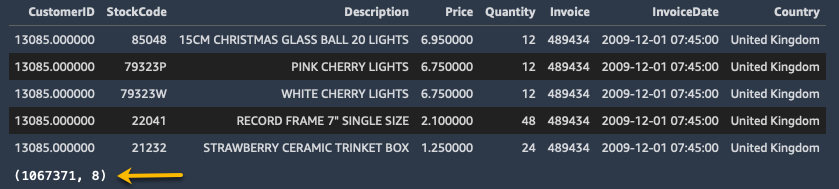

The name and the attribute information of the features from the image are as follows:

1. **CustomerID**: A 5-digit integral customer number uniquely assigned to each customer.
2. **StockCode**: A 5-digit integral product or item code number uniquely assigned to each specific product.
3. **Description**: Product or item name.
4. **Price**: Unit price. Product price per unit in sterling.
5. **Quantity**: The quantities of each product or item per transaction.
6. **Invoice**(Nominal): Invoice number. A six-digit integral number uniquely assigned to each transaction. Codes starting with the letter *c*, indicate cancellations.
7. **InvoiceDate**: Invoice date and time, which is the day and time when it generated a transaction.
8. **Country**: The name of the country where a customer resides.

Next, you will examine the downloaded datasets into the pandas dataframe and uncover the top 5 records and their datatypes. The estimated wall time for the below cell is around ~2min 20s.

```python
# This would take some time as we would be filling close 1 millon transactions from the downloaded file and creating a dataframe
raw_excel_data = pd.read_excel(
    DATASET_DIR + "/online_retail_II.xlsx",
    sheet_name=None, engine='openpyxl',
    names=[
        "Invoice",
        "StockCode",
        "Description",
        "Quantity",
        "InvoiceDate",
        "Price",
        "CustomerID",
        "Country",
    ],
)

# Since the file contains different two sheets from two years, let us combine and create a single dataframe
online_retail_data = pd.concat(raw_excel_data, axis=0, ignore_index=True)

# Print the recently created Panda Dataset's dimensionality and first five records
online_retail_data = online_retail_data[
    [
        "CustomerID",
        "StockCode",
        "Description",
        "Price",
        "Quantity",
        "Invoice",
        "InvoiceDate",
        "Country",
    ]
]

display(online_retail_data.head().style.hide_index())
print(online_retail_data.shape)
```

### Explore, clean, and convert the dataset

The *user-item-interaction* data is critical for getting started with the recommender system. Recommender systems use this data to train for use cases such as video-on-demand applications, user click-stream logs, and user purchase history. No matter the use case, the algorithms all share a base of learning on user-item-interaction data, which is defined by two core attributes:

- **user_id –** The user who interacted
- **item_id** – The item that the user interacted with

The Implicit BPR requires the training dataset to contain **user_id** and **item_id** columns. In this case, the columns are, respectively, **CustomerID** and **StockCode**, representing the items that the user purchased or interacted with. Additionally, the columns must not include any missing values, and the input file must be in a CSV format.

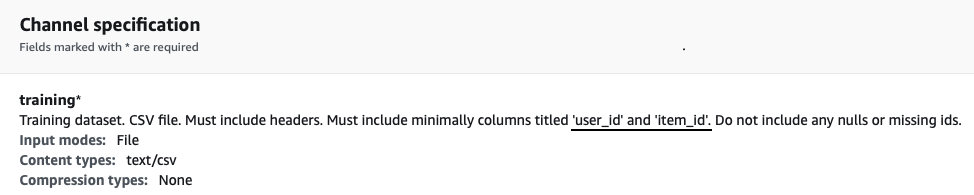

Let us evaluate and confirm that our dataset for nulls.

```python
# Checking data types and the missing values in the data
print(
    "[INFO]: Dataframe with the missing Customer IDs, its datatype values from the original dataset"
)
online_retail_data.info()
```

You can see that the dataset has close to 243007 missing values in the CustomerID column. Next, you will clean up the dataset by eliminating those missing/null rows.

```python
# Removing the rows that do not have a Customer ID
online_retail_data = online_retail_data.loc[pd.isnull(online_retail_data.CustomerID) == False]
# Convert to int for customer ID
online_retail_data["CustomerID"] = online_retail_data.CustomerID.astype(int)
# Validate data types and the missing values in the data post eliminating the missing rows
print(
    "\n[INFO]: Dataframe post eliminating Customer IDs, its datatype values from the original dataset"
)
online_retail_data.info()

print(
    "\n[INFO]: The dataset now have no null rows for the CustomerID and have approximately 824364 occurrences to analyze further and train our model"
)
```

Preparing the final training dataset and upload it to Amazon S3 - To better visualize our model's recommendation, let us assemble a product lookup table that we can use later to map with the inference results. We can also eliminate the optional columns which are not needed for the training. Finally, lets rename the columns "CustomerID" -> "user_id" and "StockCode" -> "item_id" as expected by the algorithm spec.

```python
# Build a lookup table for stock code information
stock_code_desc_look_up = online_retail_data[["StockCode", "Description"]].drop_duplicates()
stock_code_desc_look_up["StockCode"] = stock_code_desc_look_up.StockCode.astype(str)
print("[INFO]: Stock Code lookup table")
display(stock_code_desc_look_up.head().style.hide_index())

# Remove the optional columns which are not claimed for the training
cleaned_online_retail_data = online_retail_data
cleaned_online_retail_data = cleaned_online_retail_data[["CustomerID", "StockCode"]]

# Lastly, lets rename the columns "CustomerID" -> "item_id" and "StockCode" -> "item_id" as required by the algothirm specification
cleaned_online_retail_data = cleaned_online_retail_data.rename(
    columns={"CustomerID": "user_id", "StockCode": "item_id"}
)
print("[INFO]: Head of the final dataset post renaming the headers of the columns")
display(cleaned_online_retail_data.head().style.hide_index())

print(
    "[INFO] Our dataset is ultimately ready and satisfies all the required algorithm specification. We hold approximately {} user-item interactions to train our model.".format(
        cleaned_online_retail_data.shape[0]
    )
)
```

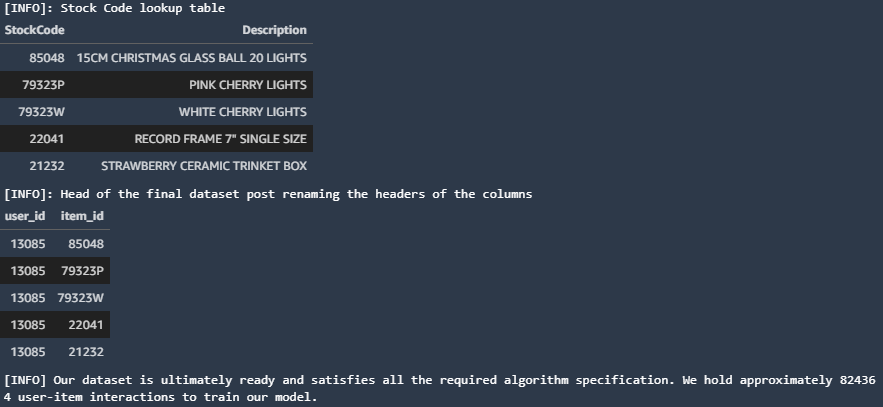

Next, let us split the dataset into the training and the testing that you can use to train and evaluate the performance of the model

```python
# Split the dataset into the training and the testing with 70% for training and 30% for testing
train_set, test_set = train_test_split(
    cleaned_online_retail_data, train_size=0.70, test_size=0.30, random_state=41
)

print(
    "[INFO] The size of the training dataset is {}, and the size of the testing dataset is {}.".format(
        len(train_set.index), len(test_set.index)
    )
)
```

Let us create a CSV file for both the training and the testing dataset and upload them to the S3 bucket

```python
train_set[["user_id", "item_id"]].to_csv(train_data_file, index=False)

# Upload the training dataset to S3
training_input = sagemaker_session.upload_data(
    TRAINING_WORKDIR, s3_bucket, key_prefix=s3_training_input_prefix
)
print("[INFO] Uploaded training data location " + training_input)
```

```python
test_set[["user_id", "item_id"]].to_csv(test_data_file, index=False)

# Upload the test dataset to S3
test_input = sagemaker_session.upload_data(
    TEST_WORKDIR, s3_bucket, key_prefix=s3_testing_input_prefix
)
print("[INFO] Uploaded testing data location " + test_input)
```

At this point, you have performed the ingestion, exploration, and generation of a clean training dataset file that meets the Implicit BPR algorithm’s requirements. You have also uploaded the training and testing dataset to the S3 bucket and can use it to train a model.

<!---------------------------->

## Train and evaluate the ML model

Duration: 10

### Train the model

To train a model, you must create a training job. After you start the training job, SageMaker launches the machine learning (ML) compute instances and uses the training code you provided to train the model. It then saves the resulting model artifacts and other output in the S3 bucket. Next, let us form and start a training job with the training dataset we uploaded to the S3 bucket and wait for the completion. The estimated wall time for the below cell is around ~4min 20s.

```python
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
job_name = job_name_prefix + timestamp

print("[INFO] Creating a training job with name: " + job_name)

# Configure an Estimator (no training happens yet)
estimator = AlgorithmEstimator(
    algorithm_arn=algorithm_arn,
    role=role_arn,
    instance_count=1,
    instance_type=compatible_training_instance_type,
    sagemaker_session=sagemaker_session,
    input_mode="File",
    output_path=job_output_path,
    base_job_name=job_name_prefix,
)

inputs = {"training": training_input, "testing": test_input}
# Starts a SageMaker training job and waits until completion
estimator.fit(inputs, logs="Training", job_name=job_name)

print("[INFO] Training the model has been completed sucessfully.")
print("[INFO] Model artifact can be found at: " + estimator.output_path + job_name)
```

### Evaluate and visualize the performance metrics

As you know, you are most likely interested in promoting top-N items to the users within the context of recommendation systems. So it is essential to measure the Precision and Recall metrics in the top-N items rather than all the items. Thus the idea of precision and recall at k where k is a user-defined integer to match the top-N recommendations' objective.

In other words, **out of all the top N items the system would recommend, how many are relevant to the user?** You can visualize the metrics p@k(10) produced from the training job inline using the Amazon SageMaker Python SDK APIs from the next cell.

```python
# Training Job Name
training_job_name = job_name

# Metric name as per the algorithm specifications
metric_name = "p@k(10)"
# Retrieve the Training job details and build a plot
metrics_dataframe = TrainingJobAnalytics(
    training_job_name=training_job_name, metric_names=[metric_name]
).dataframe()
plt = metrics_dataframe.plot(
    title="Precision at 10 in a top-10 Recommendation",
    grid=True,
    kind="line",
    figsize=(10, 5),
    x="timestamp",
    y="value",
    style="b.",
    legend=False,
)
plt.set_ylabel("Average precision at k(10)");
```

The following image from the training job logs of the previous step shows that the algorithm produced the Precision at 10 in a top-10 recommendation problem at around 85 percent. It means that about 85 percent of the recommendation the system presented are relevant to users.

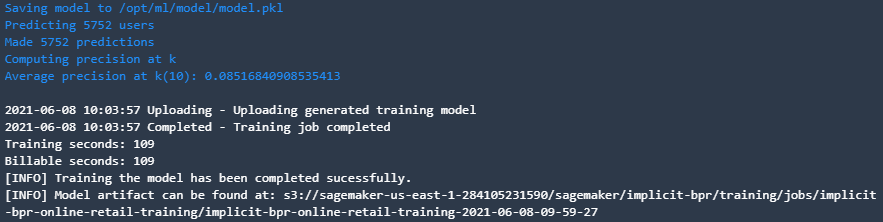

<!---------------------------->

## Perform a batch/offline inference

Duration: 15

After you build and train your models, you can deploy them to get predictions in one of two ways:

- **Batch Transform:** To get the inferences on an entire dataset offline, you run a *batch transform* job on a trained model. A batch transform automatically manages the processing of large datasets within the limits of specified parameters. For instance, consider the product or movie recommendations on a site; rather than generate new predictions each time a user logs on to the website, you may decide to create recommendations for users in batch and then cache these recommendations for easy retrieval when needed.
- **Real-time:** Many customer use cases require the system to have an HTTPS endpoint to get predictions from your models. For instance, a ride-sharing or a food delivery application where estimated time to delivery is created in real-time whenever a user requests the service. It is not helpful to have those inferences generated ahead of time as a batch and serve to users.

Many other applications can benefit from online inference, such as self-driving cars, virtual reality, and any consumer-facing mobile or web applications that allow users to query models in real-time with sub second latency. SageMaker has hosting services for model deployment, providing an HTTPS endpoint where your ML model can perform inferences.

### Batch transform

To get the inferences on an entire dataset offline, you run a batch transform job on a trained model. Batch transform automatically manages the processing of large datasets within the limits of specified parameters. When a batch transform job starts, SageMaker initializes ML compute instances and distributes the inference or preprocessing workload between them. Batch Transform partitions the Amazon S3 objects in the input by key and maps Amazon S3 objects to instances.

In this step, you will first identify sample users and prepare an input payload. Then you will run a batch transform job, and finally, you will look at the recommendations for the sample users.

### Identify a customer and understand their purchase history

Let us identify sample customers who have purchased three separate items of various kinds.

```python
# Take Customer ID: 13085 for our analysis from the original dataset
sample_customer_id = 13085
# Let us present the top 10 original purchase history for this customer.
display_original_purchase_history(online_retail_data, sample_customer_id, 10)
```

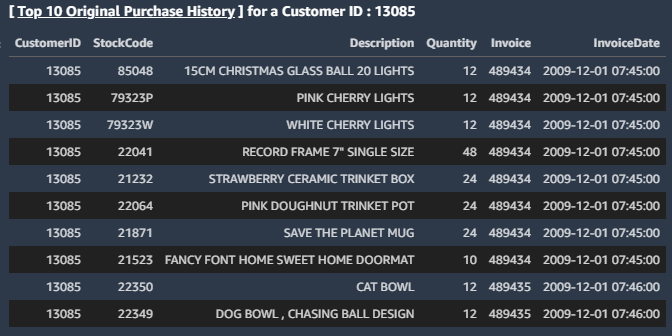

As you can see, this customer likes purchasing many different kinds of Lights, Doormats, various Bowls. Let us build a request payload for this customer and examine what new items the deployed model would recommend?

```python
# Build a local work dir where you would create the batch transform request file in a JSON format
# Populate the requested file with the preceding example users.
with open(batch_request_data_file, "w") as outfile:
    json.dump({"user_id": str(sample_customer_id), "top_n": "10"}, outfile)
    outfile.write("\n")
outfile.close()
```

Print the head of the payload file

```python
!head {batch_request_data_file}
```

### **Upload the payload to Amazon S3 and run a batch transform job**

In this section, you will upload the data to S3 and run a batch transform job. The estimated wall time for the transform job is around ~6min 30s.

```python
# Build Transform Job Name
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
transform_job_name = transform_job_name_prefix + timestamp
transform_job_inference_path = "{}/{}".format(s3_batch_input_dir_prefix, transform_job_name)
transform_job_inference_output = "s3://" + s3_bucket + "/" + transform_job_inference_path

# Upload the batch transform request JSON file dataset to Amazon S3 buket
uploaded_batch_inference_request = sagemaker_session.upload_data(
    batch_request_data_file, s3_bucket, key_prefix=transform_job_inference_path
)
print("[INFO] S3 batch requests data location " + uploaded_batch_inference_request)
```

```python
# Build the Transformer Object with the parameters
print("[INFO] Starting the batch transform job: " + transform_job_name)
transformer = estimator.transformer(
    instance_count=1,
    instance_type=compatible_batch_transform_instance_type,
    strategy="SingleRecord",
    output_path=transform_job_inference_output,
    assemble_with="Line",
    accept="text/csv",
)
# Strat the Transformer Job
transformer.transform(
    data=uploaded_batch_inference_request,
    job_name=transform_job_name,
    content_type="application/json",
    compression_type="None",
    split_type="Line",
    logs=False,
)

# Wait until the job completes
transformer.wait()
print(
    "[INFO] The batch transform job has been completed, and the output has been saved to : "
    + transformer.output_path
)
```

### Next, lets us examine the Batch Transform output in S3

```python
parsed_url = urlparse(transformer.output_path)
bucket_name = parsed_url.netloc
file_key = "{}/{}.out".format(parsed_url.path[1:], s3_batch_request_file_name)

response = boto_s3_client.get_object(Bucket=sagemaker_session.default_bucket(), Key=file_key)
s3_response_bytes = response["Body"].read().decode("utf-8")

print(s3_response_bytes)
```

As you can see, the inference output not only includes the User Id, Item Id that it would recommend but also consists of the Ranking Score in an order which is most relevant to this user.

### Join the result with the stock lookup table to associate the item information

```python
# Read the Batch transform response and create a Panda's Dataframe for more useful visualization.
batch_inference_response = StringIO(s3_response_bytes)

recommendations_df = pd.read_csv(
    batch_inference_response, header=None, names=["CustomerID", "StockCode", "Recommendation Score"]
)

# Model inference result to associate and endorse our predictions
display_inference_result(recommendations_df, sample_customer_id, "batch")
```

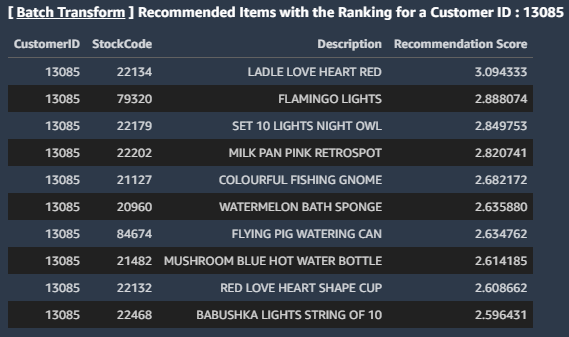

You can see that the model correctly predicted the next few articles that this customer would choose to like to purchase, such as different additional Lights and Bathroom Curtain Sets, including other items Cups.

<!---------------------------->

## Deploy the model and perform a real-time inference

Duration: 10

### Deploy an endpoint

The estimator.deploy method creates the deployable model, configures the SageMaker hosting services endpoint, and launches the endpoint to host the model. The estimated wall time for the below cell is around ~7min 25s.

```python
# Creates the deployable model, configures the SageMaker hosting services endpoint, and launches the endpoint to host the model.
predictor = estimator.deploy(
    1, compatible_real_time_inference_instance_type, serializer=json_serializer
)
print("[INFO] The model endpoint has been deployed successfully")
```

### Take the example user, create the JSON payload and make an inference request

Let’s take another customer for our analysis from the original dataset and make an online inference request. You will be able to see the JSON response received from SageMaker Model Endpoint.

```python
example_customer_id = 17519
# Let us present the top 10 original purchase history for this customer.
display_original_purchase_history(online_retail_data, example_customer_id, 10)
```

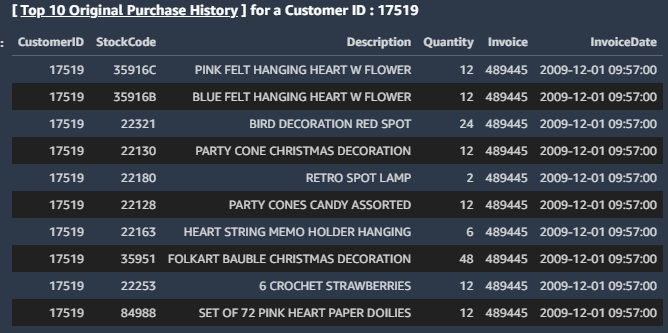

As you can see, this customer prefers purchasing events related decorative items such as Paper dollies, Banners, and Assorted items. Let us build a request payload for this customer and review what new things the deployed model would recommend?

```python
response_dict = ""
top_n = 10

# Build the JSON Inference request
json_inference_request = {"user_id": str(example_customer_id), "top_n": str(top_n)}
# Make an Inference Request to the deployed Endpoint
response = boto3_sm_runtime.invoke_endpoint(
    EndpointName=predictor.endpoint,
    Body=json.dumps(json_inference_request),
    ContentType="application/json",
)
inference_response_body = response["Body"].read().decode("utf-8")
response_dict = eval(inference_response_body)
print("[INFO] JSON Response received from SageMaker Model Endpoint: ")
display(response_dict)
```

### Join the result with the stock lookup table to associate the item information

```python
if len(response_dict) > 0:
    online_response_df = pd.read_json(json.dumps(response_dict))
    # Model inference result to associate and endorse our predictions
    display_inference_result(online_response_df, example_customer_id, "realtime")
else:
    print(
        "[INFO] No response received for the request with Real-Time Inference for CustomerID {}.".format(
            customer_id
        )
    )
```

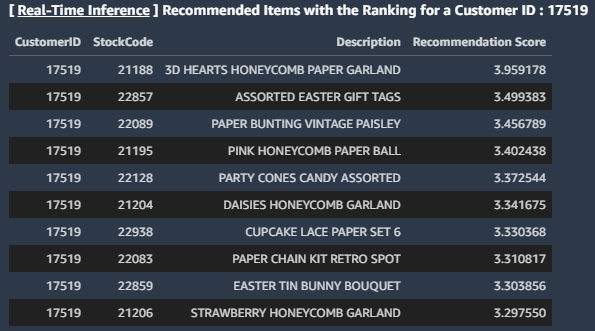

You can see that the model correctly predicted the next few articles that this customer would choose to like to purchase, such as Hanging tags, Cake stands, Garland including, Gift Tags, and various Birthday signs.

<!---------------------------->

## Cleaning up

Duration: 5

### Cleaning up the Resources

To avoid incurring unnecessary costs, delete the resources you created, such as deployed Amazon SageMaker Model endpoint and the deployed model, downloaded external datasets, and temporary ones made on this Notebook. Follow [these instructions](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html?&ref_=sa_campaign_niravraj) in the *Amazon SageMaker Developer Guide*.

```python
predictor.delete_model()
predictor.delete_endpoint()
estimator.delete_endpoint()
```

```python
rm -rf $DATASET_DIR $TRAINING_WORKDIR $TEST_WORKDIR $BATCH_REQUEST_WORKDIR
```

### Unsubscribe the product from AWS Marketplace (optional)

Lastly, if the AWS Marketplace subscription was created just for the experiment and you would like to unsubscribe to the product, you can follow the following steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package using the algorithm. Note - You can find this information by looking at the container name associated with the model.

1. Navigate to **Machine Learning** tab on **[Your Software subscriptions page](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=lbr_tab_ml)**
2. Locate the listing that you would need to cancel the subscription for, and then you can click **Cancel subscription** to cancel the subscription

<!---------------------------->

## Conclusion

Duration: 2

Congratulations!

### What we've covered

- Demonstrated how to use Implicit BPR in AWS Marketplace to improve the personalized ranking in any recommender system
- Showed how to subscribe to the model, create the SageMaker notebook instance, train and deploy the model, and experiment with the sample code
- Showed how to perform both batch and real-time inferences on the hosted model using different example users from the original dataset and visualize their inference results ordered by recommendation score to be most relevant to those users

### Next steps

Here are some additional resources I recommend checking out:

1. [Buy and sell Amazon SageMaker algorithms and models in AWS Marketplace](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-marketplace.html?&ref_=sa_campaign_niravraj)
2. [Use algorithm and model package resources in AWS Marketplace](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-mkt-buy.html?&ref_=sa_campaign_niravraj)
3. [Amazon SageMaker k-nearest neighbors (k-NN) algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/k-nearest-neighbors.html?&ref_=sa_campaign_niravraj)
4. [Amazon SageMaker factorization machines algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines.html?&ref_=sa_campaign_niravraj)
5. [Whitepaper on Bayesian personalized ranking from implicit feedback](https://arxiv.org/pdf/1205.2618.pdf)
6. [Whitepaper on adapting K-Nearest Neighbor for tag recommendation in folksonomies](http://ceur-ws.org/Vol-528/paper8.pdf)

### Links and References

1. [https://aws.amazon.com/blogs/awsmarketplace/improving-personalized-ranking-in-recommender-systems-with-implicit-bpr-and-amazon-sagemaker/](https://aws.amazon.com/blogs/awsmarketplace/improving-personalized-ranking-in-recommender-systems-with-implicit-bpr-and-amazon-sagemaker/)
2. [https://nbviewer.jupyter.org/github/aws/amazon-sagemaker-examples/blob/master/aws_marketplace/using_algorithms/implicit_bpr/recommender_system_with_implicit_bpr.ipynb](https://nbviewer.jupyter.org/github/aws/amazon-sagemaker-examples/blob/master/aws_marketplace/using_algorithms/implicit_bpr/recommender_system_with_implicit_bpr.ipynb)